# Constraint Analysis

* This notebooks shows you how to create a constraint analysis diagram. The numbers here are rough estimates. You should further refine and verify these numbers with your team. You may wish to add additional constraints, or remove existing constraints, to represent the reuqirements in the RFP.

## Definitions
* Thrust to Weight Ratio: Sea-level static thrust/ Maximum takeoff weight
* Wing Loading: Maximum takeoff weight / wing area

## Why use Casadi?
* Automatic differentiation (computes gradients for you)
* Overkill for this application, but can be used in later stages of your design cycle when optimizations get more complex

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 7)  # makes figures larger by default

### Master Equation for Jet

See Mattingly Chapter 2, and Loftin Chapter 7.

$$\frac{T}{W} = \frac{\beta}{\alpha} \left\{
    \frac{q}{\beta}\left[
        \frac{C_{D_0} + C_{D_C}}{W/S} + \frac{1}{\pi AR e} \left(\frac{n \beta}{q}\right)^2 \frac{W}{S}
    \right]
    + \frac{1}{V} \frac{dh}{dt} + \frac{1}{g} \frac{dV}{dt}
    \right\}$$

In [2]:
def T_W_cruise(W_S):
    # cruise flight, master equation

    beta = 1  # weight fraction (current weight/gross weight), []
    AR = 5  # aspect ratio, []
    g = 9.8 # accel of gravity, [m/s^2]
    V = 240 # cruise velocity (0.7 Mach), [m/s]
    rho = 0.4135 # air density at service ceiling of 10,000 m, [kg/m^3]
    q = 0.5*rho*V**2  # dynamic pressure at cruise
    alpha = 0.3 # engine lapse rate (thrust/ thrust sea level), []
    e = 0.7 # oswald efficiency factor
    V_climb = 0 # climb rate at service ceiling, [m/s]
    n = 1 # load_factor (L/W), 1 when in steady level flight, >1 when turning, []
    CD0 = 0.02 # Parasite Drag Coefficient, []
    CDC = 0  # Compressibility Drag Coefficient, []
    accel = 0  # acceleration, [m/s^2]
    pi = np.pi # constants from numpy

    # required thrust to weight
    return (beta/alpha)*(
        (q/beta)*(
            (CD0 + CDC)/W_S
            + (1/(pi*AR*e))*(n*beta/q)**2*(W_S)
        )
        + (1/V)*V_climb + (1/g)*accel
    )

## Takeoff Distance for V/STOL

From Kohlman, page 83
$$ S_g = \left[\dfrac{W}{\sigma S C_{L_{TO}}} \right] \frac{1}{\frac{T}{W}} \dfrac{1}{g \rho_0}$$

This can be rearranged to:
$$ \dfrac{T}{W} = \left[\dfrac{\frac{W}{S}}{\sigma C_{L_{TO}}} \right]  \dfrac{1}{S_g g \rho_0}$$

In [3]:
def T_W_takeoff_distance(W_S):
    # stol jet takeoff, non-vectored thrust
    # kohlman, pg. 83
    CL_TO = 1.8  # lift coefficient at take-off, []
    rho = 1.225  # air density at sea level, [kg/m^3]
    sigma = 1  # Area_exit / Area_rotor, []
    Sg_min = 305  # minimum takeoff distance, [m], STOL definition https://en.wikipedia.org/wiki/STOL
    g = 9.8 # accel of gravity, [m/s^2]
    # reqtured thrust to weight
    return (W_S/(sigma*CL_TO))*(1/(Sg_min*g*rho))

## Takeoff Distance for V/STOL with Thrust Vectoring

$$ S_{g\theta} = S_g \sqrt{1 - (T/W)^2} $$

Where $S_{g\theta}$ is the takeoff distance when optimally thrust vectoring, and $S_g$ is the takeoff distance without thrust vectoring.

In [4]:
import sympy
theta = sympy.symbols('theta')
T_W = sympy.symbols('\\frac{T}{W}')
W_S = sympy.symbols('\\frac{W}{S}')
S_g = sympy.symbols('S_g')
S_go = sympy.symbols('S_{go}')

CL_TO = sympy.symbols('CL_{TO}')
g = sympy.symbols('g')
sigma = sympy.symbols('sigma')
rho_0 = sympy.symbols('rho_0')

eq1 = S_go - S_g*sympy.sqrt(1 - T_W**2)  # optimal thrust vectoring angle
eq2 = S_g - W_S/(sigma*CL_TO*g*rho_0*T_W)
S_go_sol = sympy.solve([eq1, eq2], [S_g, T_W], dict=True)[0][T_W]
sympy.Eq(T_W, S_go_sol)

Eq(\frac{T}{W}, \frac{W}{S}*sqrt(1/(CL_{TO}**2*S_{go}**2*g**2*rho_0**2*sigma**2 + \frac{W}{S}**2)))

In [5]:
### Takeoff Distance for V/STOL with Thrust Vectoring

def T_W_takeoff_distance_vectored(W_S):
    # stol jet takeoff, non-vectored thrust
    # kohlman, pg. 83
    CL_TO = 1.8  # lift coefficient at take-off, []
    rho_0 = 1.225  # air density at sea level, [kg/m^3]
    sigma = 1  # Area_exit / Area_rotor, []
    Sg_min = 305  # minimum takeoff distance, [m], STOL definition https://en.wikipedia.org/wiki/STOL
    g = 9.8 # accel of gravity, [m/s^2]
    # reqtured thrust to weight
    return W_S*((CL_TO*Sg_min*g*rho_0*sigma)**2 + W_S**2)**(-0.5)

## Landing

In [6]:
def W_S_landing(T_W):
    S_g = 305
    g = 9.8
    rho = 1.225
    C_D = 1 # should do drag build up
    CL_land = 2
    mu = 0.15
    beta = 0.5
    W_S = S_g*g*rho*C_D/(beta*np.log(1 + (1.15)**2*C_D/(CL_land*mu*beta)))
    # returns W_S
    return W_S*np.ones(T_W.shape)

## Hover

In [7]:
def T_W_hover(W_S):
    T_W_hover = 1.2
    # returns T_W
    return T_W_hover*np.ones(W_S.shape)

### Optimization

In [8]:
def solve(t_w_constraints, w_s_constraints):
    """
    Takes a dictionary of functions and then solves the constraint analysis problem
    """
    
    # declare symbolic variables for the design vector we are solving for
    W_S = ca.SX.sym('W_S') # wing loading, weight/(wing area)
    T_W = ca.SX.sym('T_W') # thrust to weight
    n_constraints = len(t_w_constraints) + len(w_s_constraints)
    
    # assemble constraints
    constraints = [T_W - f(W_S) for f in t_w_constraints] + [f(T_W) - W_S for f in w_s_constraints]
    
    solver = ca.nlpsol(
        'problem',  # name
        'ipopt',  # solver
        {  # problem details
            'x': ca.vertcat(W_S, T_W),  # decision variables/ design vector
            'f': T_W - 1e-6*W_S,  # objective function, minimize thrust/weight and maximize wing loading (keep weight low)
            'g': ca.vertcat(*constraints)  # constraints
        },
        {  # solver options
            'print_time': 0,
            'ipopt': {
                'sb': 'yes',
                'print_level': 0,
            }
        }
    )

    # Solve the problem
    res = solver(
        x0=[3000, 0.5], # initial guess for (W_S, P_W)
        lbg=[0]*n_constraints,  # lower bound on constraints
        ubg=[ca.inf]*n_constraints,  # upper bound on constraints
        lbx=[0, 0],  # lower bound on state
        ubx=[6000, 2],  # upper bound on state
    )
    stats = solver.stats()
    
    # If the solver failed, raise an exception
    if not stats['success']:
        raise RuntimeError(stats['return_status'])
    return {
        'W_S': float(res['x'][0]),
        'T_W': float(res['x'][1]),
    }

In [9]:
def constraint_analysis(t_w_funcs, w_s_funcs):
    """
    The main function that creates functions, solves the optimization problem, and then plots the constraint
    analysis diagram with the optimal design point labelled.
    
    t_w_funcs: A list of functions that compute required thrust to weight as a function of wing loading
    
    w_s_funcs: A list of functions that compute required wing loading as a function of thrust to weight
    """
    g = 9.8
    m_S_max = 800  # maximum wing loading plotted [kg/m^2]
    T_W_max = 2    # maximum thrust to weight plotted []
    
    # note it is common to express Wing Loading as [kg/m^2], so we will convert the units here
    m_S_val = np.linspace(1e-3, m_S_max, 1000)  # wing loading in kg/m^2
    W_S_val = m_S_val*g  # wing loading in N/m^2
    T_W_val = np.linspace(0, T_W_max, 1000)
    
    for f in t_w_funcs:
        name = f.__name__
        plt.plot(W_S_val/g, f(W_S_val), label=name)
 
    for f in w_s_funcs:
        name = f.__name__
        plt.plot(f(T_W_val)/g, T_W_val, label=name)

    plt.xlabel('Wing Loading, [kg/m^2]')
    plt.ylabel('Thrust to Weight Ratio, []')
    plt.grid()
    plt.title('Constraint Analysis')

    # existing aircraft
    def plot_aircraft(m_W, T_W, name):
        plt.text(m_W, T_W, 'x')
        plt.text(m_W+5, T_W + 0.05, name, color='blue', alpha=0.5)
        
        
    # https://en.wikipedia.org/wiki/McDonnell_Douglas_AV-8B_Harrier_II
    plot_aircraft(14100/22.61, (105e3/g)/14100, 'Harrier') # max takeoff weight

    # https://en.wikipedia.org/wiki/Lockheed_Martin_F-35_Lightning_II    
    plot_aircraft(27200/42.74, 0.9, 'F-35B') # STOL, at takeoff (full fuel)
    plot_aircraft(31800/42.74, 0.87, 'F-35A')  # CTOL, at takeoff (full fuel)
    
    plot_aircraft(286, 0.45, 'Learjet 31')
    
    # https://en.wikipedia.org/wiki/Embraer_Phenom_100
    plot_aircraft(4800/12.3, (2*7.7e3/g)/4800, 'Phenom 100')
    
    # https://en.wikipedia.org/wiki/Cessna_Citation_X
    plot_aircraft(16600/48.96, (2*31.29e3/g)/16600, 'Citation X')  # max takeoff weight

    # design
    opt_sol = solve(t_w_funcs, w_s_funcs)
    m_S_d = opt_sol['W_S']/g
    T_W_d = opt_sol['T_W']
    plt.plot(m_S_d, T_W_d, 'r.', markersize=20, label='design point')
    plt.text(m_S_d, T_W_d + 0.1, '({:0.3g}, {:0.3g})'.format(m_S_d, T_W_d))
    plt.axis([0, m_S_max, 0, T_W_max])
    
    plt.legend(loc='upper right', ncol=2)

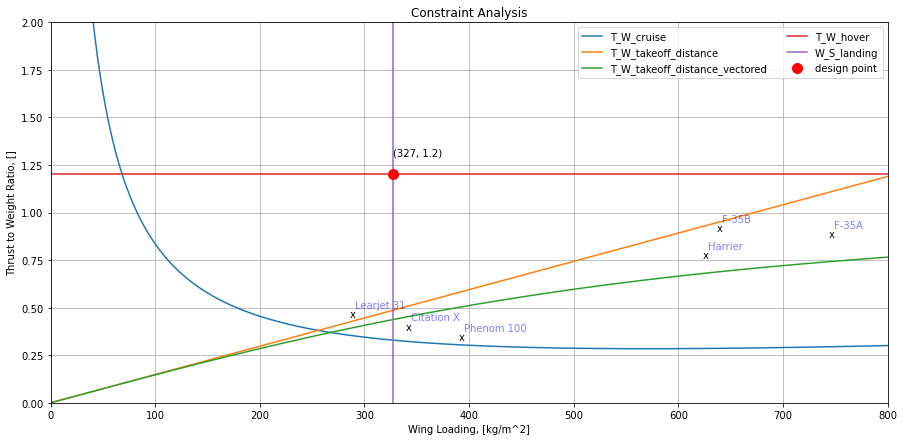

In [10]:
constraint_analysis(
    t_w_funcs=[T_W_cruise, T_W_takeoff_distance, T_W_takeoff_distance_vectored, T_W_hover],
    w_s_funcs=[W_S_landing]
)